In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split

import datetime


In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

In [8]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
data.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
data["IP_country"] = data.ip_address.apply(IP_to_country)

Basic EDA

In [24]:
int(data["class"].mean()*1000)/10 #9.3% of the data is fraud

9.3

In [4]:
# dont run this
device_duplicates = pd.DataFrame(data.groupby(by = "device_id").device_id.count())
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           
device_duplicates.reset_index(level=0, inplace= True)                                  

dupli = device_duplicates[device_duplicates.freq_device >1]

dupli = device_duplicates[device_duplicates.freq_device >2]

data = data.merge(device_duplicates, on= "device_id")

In [5]:
data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,IP_country,freq_device
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,356404,2015-02-04 10:27:49,2015-05-07 19:37:56,41,FXBMCMIOLLNCJ,SEO,Chrome,M,26,1.827348e+09,0,United States,1
151108,151643,2015-02-15 20:03:27,2015-05-07 19:28:52,23,THQOCEAVXXAIW,Ads,FireFox,M,18,1.691181e+09,0,United States,1
151109,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,1
151110,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,1


c:\Users\darkk\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\darkk\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[[<matplotlib.axis.XTick at 0x13484366508>,

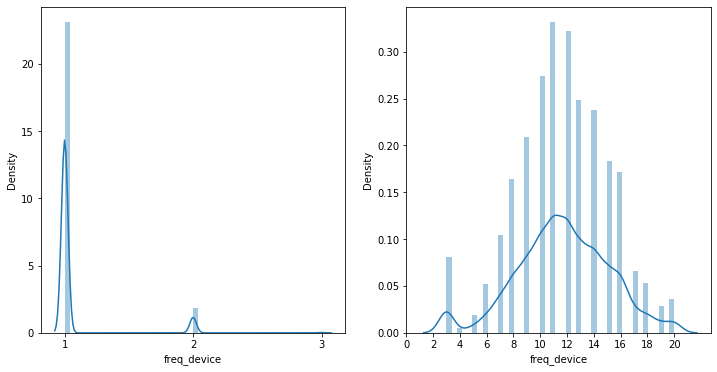

In [7]:
f, ax = plt.subplots(1,2,figsize=(12,6))
g1 =sns.distplot(data.freq_device[data.freq_device <4], ax=ax[0])
g1.set(xticks=[1,2,3])

g2 =sns.distplot(data.freq_device[data.freq_device >2], ax=ax[1])
g2.set(xticks = range(0,21,2))

In [29]:
data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,days,time,seconds,fast_purchase,month_purchase,weekday_purchase,hour_of_the_day,time_of_day,risk_country,freq_device_y
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,-53,00000000,72518,0,April,Saturday,2,late night,Low Risk,1
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,-69,00000000,1898,0,April,Thursday,17,afternoon,Low Risk,1
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,-8,00000000,28551,0,August,Monday,5,early morning,Low Risk,1
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,-1,00000000,3863,0,January,Monday,12,early afternoon,Low Risk,2
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,...,-110,00000000,36450,0,April,Tuesday,2,late night,Low Risk,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,...,-44,00000000,63299,0,April,Saturday,2,late night,Low Risk,1
151108,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,...,-8,00000000,62490,0,February,Tuesday,2,late night,Low Risk,1
151109,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,...,-68,00000000,59818,0,June,Wednesday,5,early morning,Low Risk,1
151110,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,...,-13,00000000,66495,0,May,Thursday,20,evening,Low Risk,1


In [9]:
data['freq_device'].astype(int)

0          1
1          1
2         12
3         12
4         12
          ..
151107     1
151108     1
151109     1
151110     1
151111     1
Name: freq_device, Length: 151112, dtype: int32

In [12]:
data['diff_dt']

0        52 days 03:51:22
1         0 days 04:59:04
2         0 days 00:00:01
3         0 days 00:00:01
4         0 days 00:00:01
               ...       
151107   92 days 09:10:07
151108   80 days 23:25:25
151109   10 days 18:41:10
151110   77 days 08:00:16
151111   40 days 19:01:33
Name: diff_dt, Length: 151112, dtype: timedelta64[ns]

In [9]:
import calendar
data['signup_time'] =  pd.to_datetime(data['signup_time'], format='%Y-%m-%d %H:%M:%S')
data['purchase_time'] =  pd.to_datetime(data['purchase_time'], format='%Y-%m-%d %H:%M:%S')
# get diff in days, time, seconds, fast_purchase from purchase_time and signup_time
data['diff_dt'] = data['signup_time'] - data['purchase_time']
data['days'] = data['diff_dt'].dt.days
data['time'] = data['diff_dt'].astype(str).apply(lambda x : x[-8:])
#data["time"] = pd.to_datetime(data['time'],format= '%H:%M:%S' ).dt.time
data['seconds'] = data['diff_dt'].dt.seconds
data['fast_purchase'] = data['seconds'].apply(lambda x: '1' if x < 30 else '0')

# get month, week, hour of the day from purchase_time
data['month_purchase'] = pd.to_datetime(data['purchase_time']).dt.strftime('%B')
data['weekday_purchase'] = pd.to_datetime(data['purchase_time']).dt.strftime('%A')
data['hour_of_the_day'] = pd.to_datetime(data['purchase_time']).dt.strftime('%H').astype(int)

# categorise hour of the day
data["time_of_day"] = data['hour_of_the_day'].apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early afternoon" if x < 16 else
                                                             "afternoon" if x < 20 else
                                                             "evening"
                                                            )

# get country risk from mean of class
risk_country = pd.DataFrame(data.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))
risk_country["risk_country"] = risk_country["class"].apply(lambda x:"High Risk" if x > 0.25 else "Medium Risk" if x > 0.10 else "Low Risk")
data = data.merge(risk_country.drop("class",axis=1),left_on='IP_country', right_on = 'IP_country')

# get count of duplicated devices
device_duplicates = data.groupby('device_id')['device_id'].count().rename('freq_device').reset_index()
data = data.merge(device_duplicates, on='device_id')
data['freq_device_cat'] = data['freq_device'].apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# get count of countries by device_id
country_count = data.groupby(["device_id", "IP_country"])['IP_country'].count().rename('country_count').reset_index()
data = data.merge(country_count, on=["device_id", 'IP_country'], how='left')

# get count of same purchase by device_id
duplicate = data.groupby(['device_id', 'purchase_value'])['purchase_value'].count().rename('freq_same_purchase').reset_index()
data = data.merge(duplicate, on=['device_id', 'purchase_value'], how='left')
data["freq_same_purchase_cat"] = data['freq_same_purchase'].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )

# categorise age
data["age_category"] = data['age'].apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

In [12]:
country_count = data.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
data = data.merge(country_count, left_on="device_id", right_index=True)
data.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

In [13]:
data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'IP_country', 'diff_dt', 'days', 'time', 'seconds', 'fast_purchase',
       'month_purchase', 'weekday_purchase', 'hour_of_the_day', 'time_of_day',
       'risk_country', 'freq_device', 'freq_device_cat', 'country_count',
       'freq_same_purchase', 'freq_same_purchase_cat', 'age_category',
       'countries_from_device'],
      dtype='object')

In [7]:
data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,month_purchase,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,April,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,April,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,August,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,January,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,September,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,...,April,Saturday,2,3738301.0,1,Low risk,0,0,< 40,late night
132261,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,...,February,Tuesday,2,628710.0,1,Low risk,0,0,< 40,late night
135452,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,...,June,Wednesday,5,5815382.0,1,Low risk,0,0,< 40,early morning
137201,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,...,May,Thursday,20,1056705.0,1,Low risk,0,0,< 40,evening


In [14]:
data.freq_same_purchase

0         0
61        0
70        0
84        0
91        0
         ..
127261    0
132261    0
135452    0
137201    0
148104    0
Name: freq_same_purchase, Length: 151112, dtype: object

In [15]:
data.IP_country.value_counts()

United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Niger                 1
Vanuatu               1
Yemen                 1
Cape Verde            1
Tajikistan            1
Name: IP_country, Length: 182, dtype: int64

Categorical Variables 

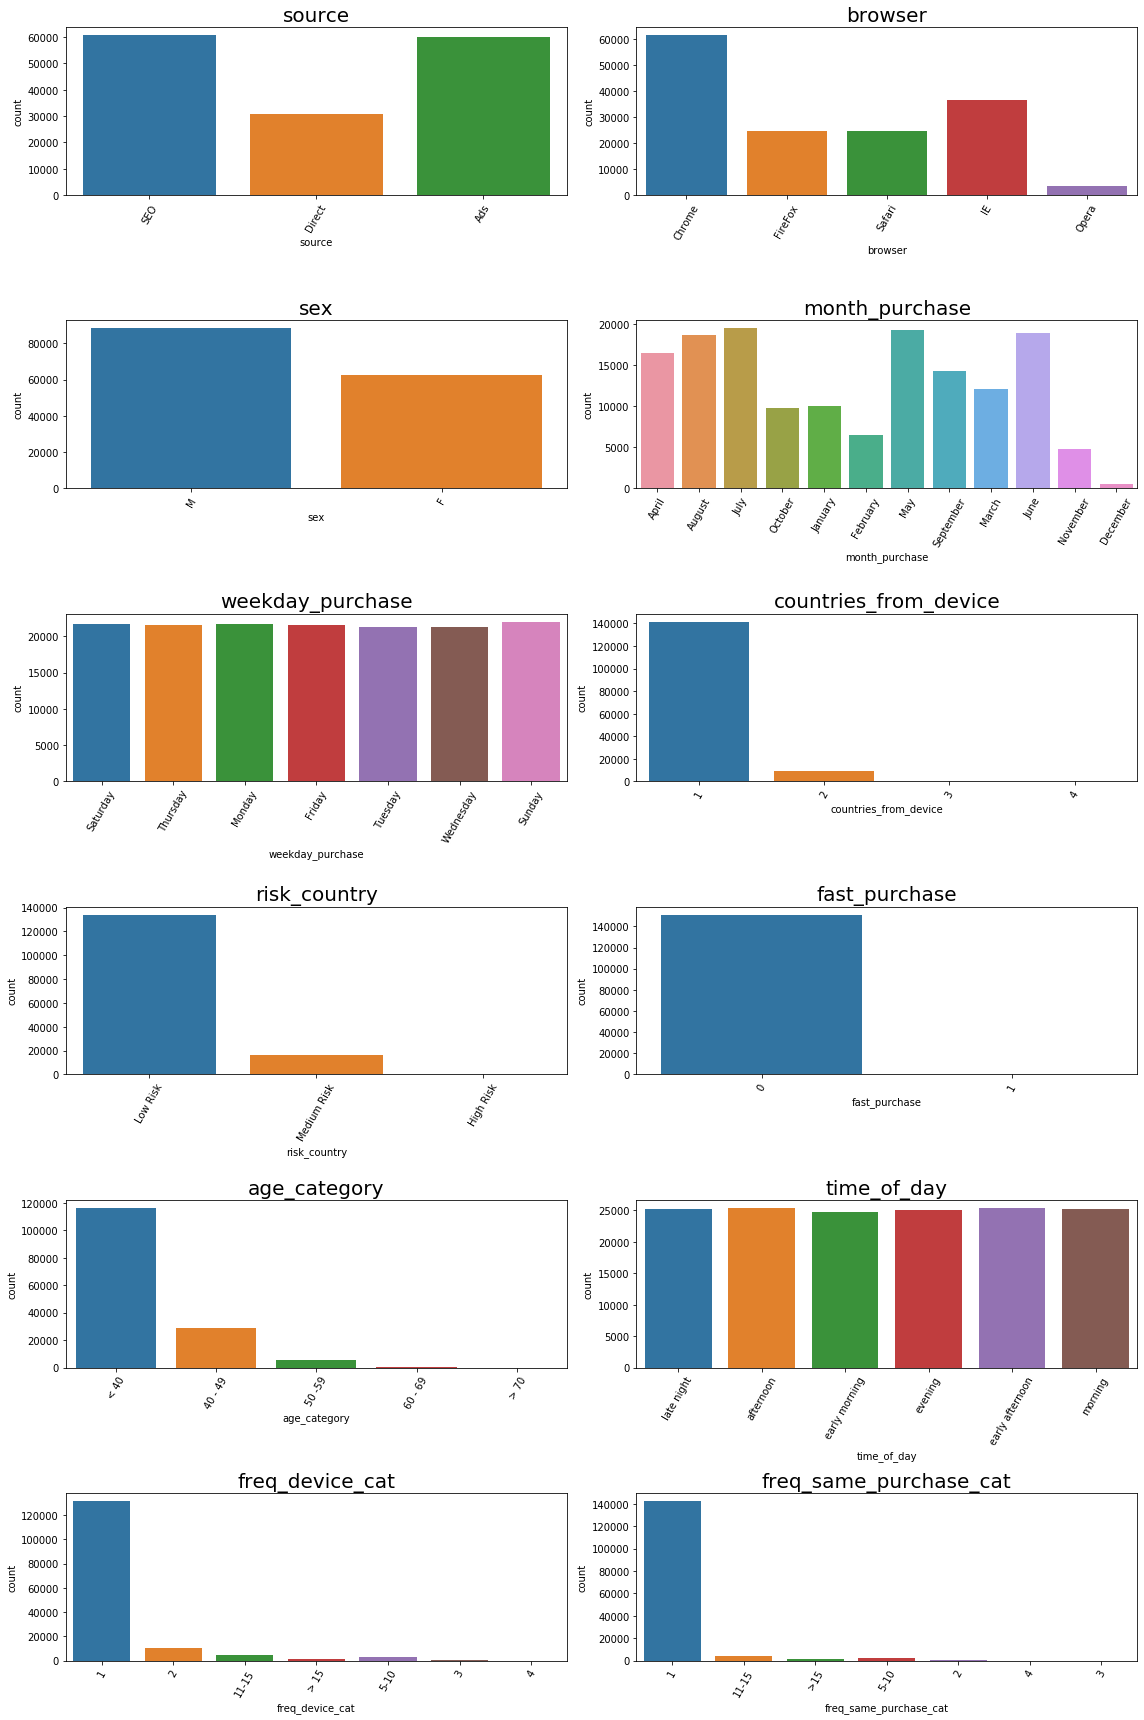

In [14]:
# Set up the matplotlib figure
cat_variables = data[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device_cat', 'freq_same_purchase_cat']]

f, axes = plt.subplots(6, 2, figsize=(16, 24), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

In [15]:
cat_encoded = pd.get_dummies(data[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device_cat', 'freq_same_purchase_cat']])

Numerical Variables

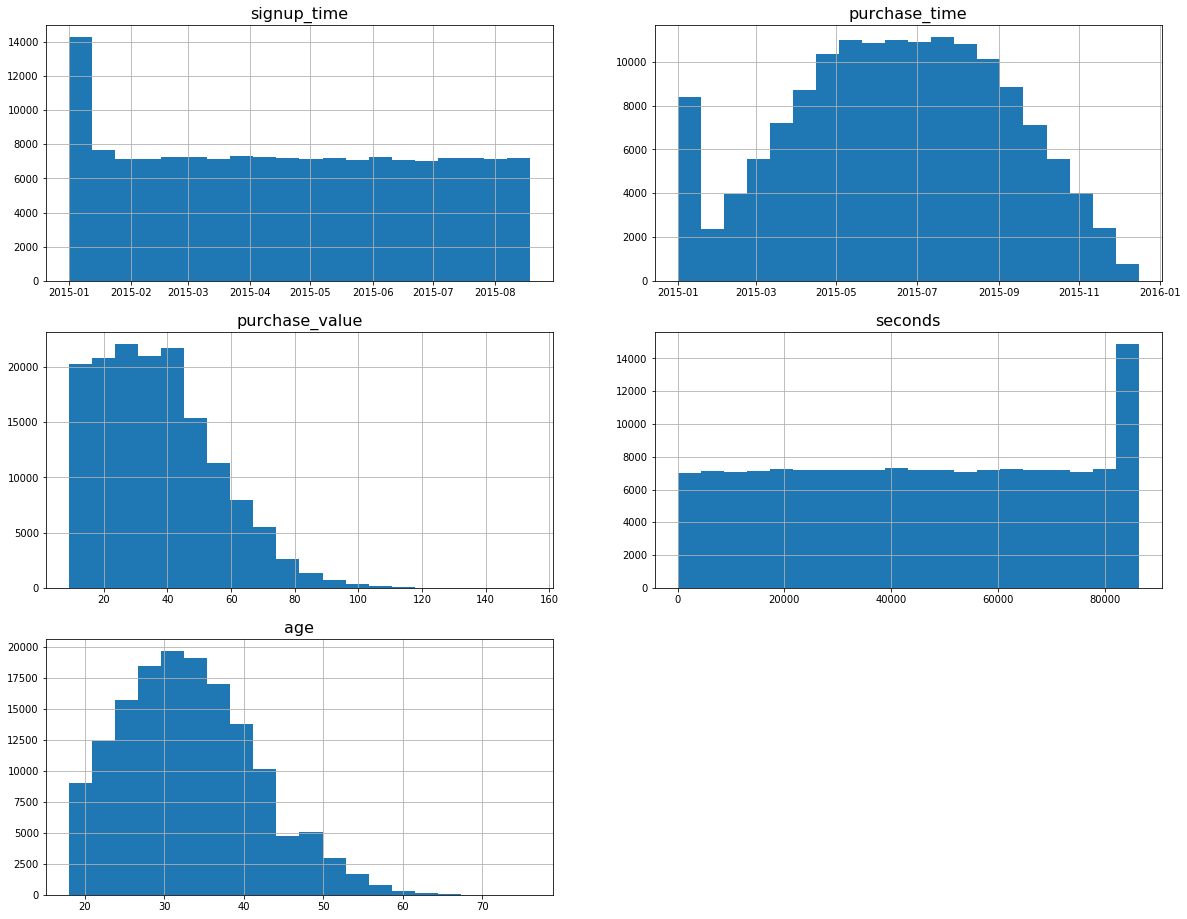

In [17]:
numerical_variables = ['signup_time', 'purchase_time', 'purchase_value', 'seconds', 'age']
plt.figure(figsize=(20,16))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(data[numerical_variables].columns):
    axes[index] = plt.subplot(3, 2, index+1, label=str(index))
    data[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

Correlation Analysis

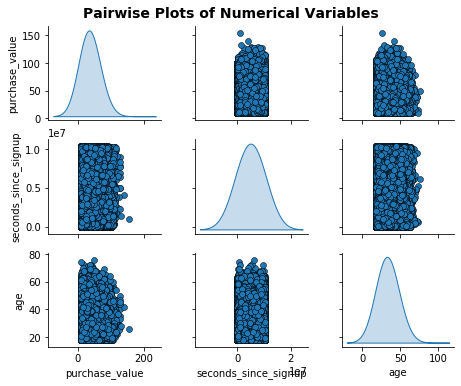

In [19]:
pg = sns.pairplot(data[numerical_variables], 
                  height=1.8, aspect=1.2,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", 
                  diag_kws=dict(shade=True, bw_method=1.5)
                 )
fig = pg.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots of Numerical Variables', fontsize=14, fontweight='bold')

Train test split

In [18]:
numerical = data[['purchase_value', 'seconds', 'age']]

dataset = pd.concat([cat_encoded, numerical], axis = 1)

In [11]:
dataset

,countries_from_device,quick_purchase,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,...,freq_same_purchase_0.0,freq_same_purchase_2.0,freq_same_purchase_3.0,freq_same_purchase_4.0,freq_same_purchase_11-15,freq_same_purchase_5-10,freq_same_purchase_>15,purchase_value,seconds_since_signup,age
0,1,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,34,4506682.0,39
61,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,72,5959702.0,32
70,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,52,662649.0,44
84,2,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,67,82537.0,49
91,2,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,33,5951052.0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,1,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,26,3738301.0,23
132261,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,12,628710.0,34
135452,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,18,5815382.0,24
137201,1,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,45,1056705.0,30


In [19]:
X = dataset
y = data[['class']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

XGBoost Feature Importance

In [21]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


In [22]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [23]:
X_train.columns

Index(['countries_from_device', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'month_purchase_April',
       'month_purchase_August', 'month_purchase_December',
       'month_purchase_February', 'month_purchase_January',
       'month_purchase_July', 'month_purchase_June', 'month_purchase_March',
       'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High Risk',
       'risk_country_Low Risk', 'risk_country_Medium Risk', 'fast_purchase_0',
       'fast_purchase_1', 'age_category_ > 70', 'age_category_40 - 49',
       'age_category_50 -59', 'age_category_60 - 69', 'age_categor

c:\Users\darkk\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\darkk\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\darkk\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[23:29:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


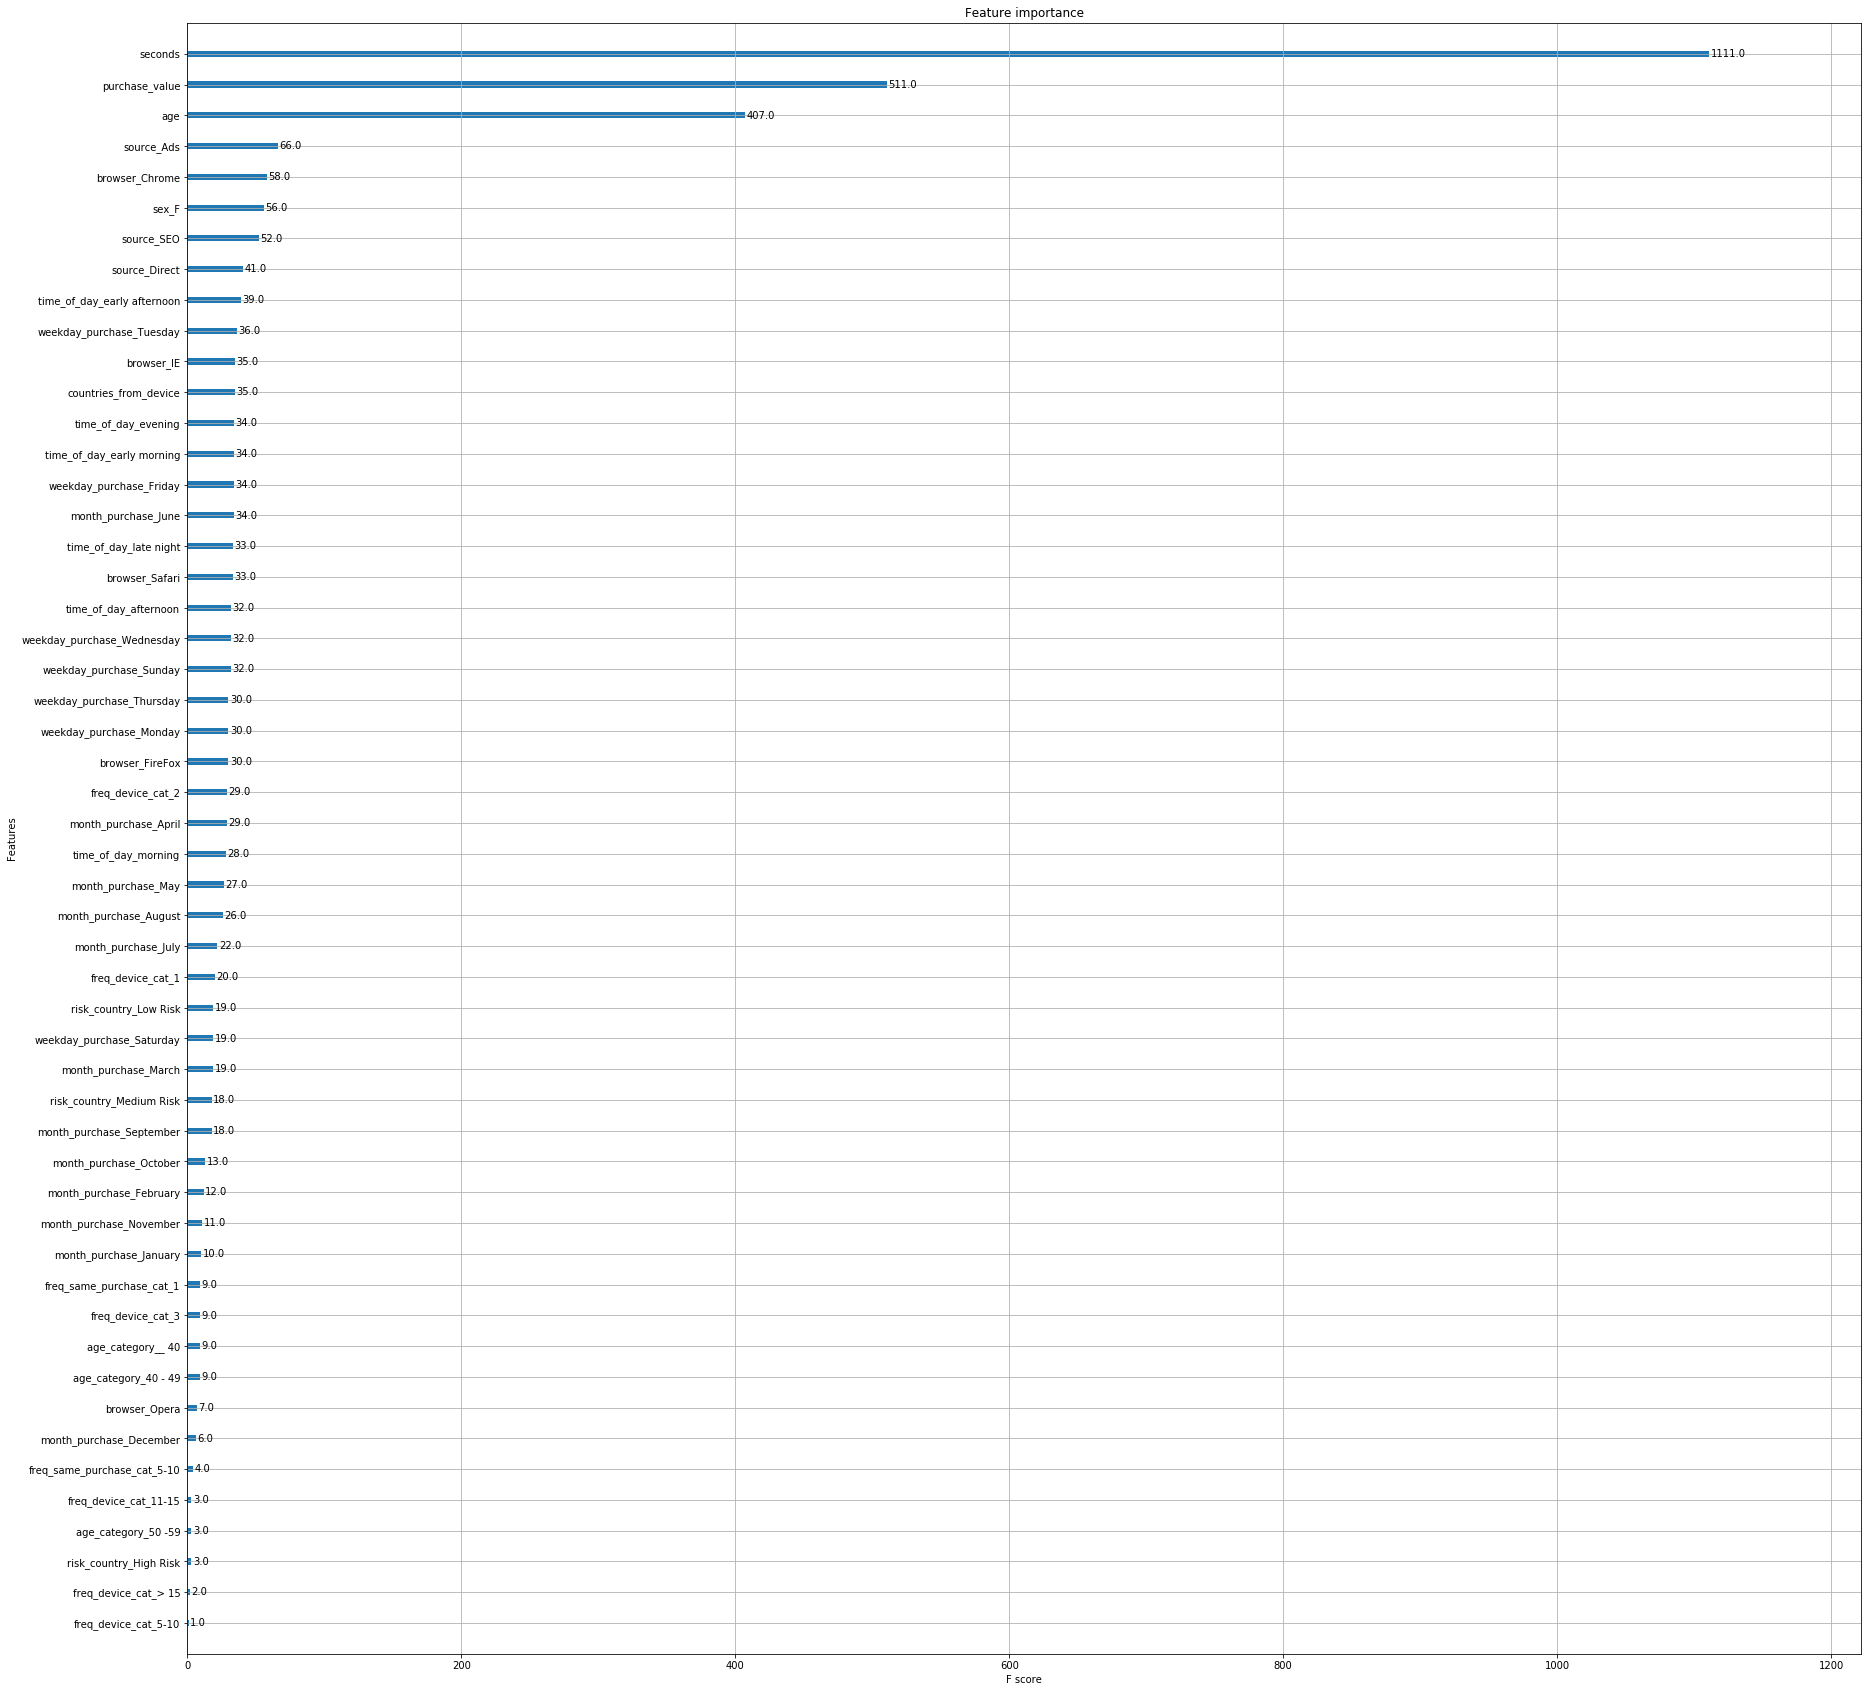

In [24]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))



RFE to do feature selection

In [25]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_


c:\Users\darkk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([24, 13,  1, 23,  1,  8,  2, 28, 17,  1, 12,  6, 18, 34, 22, 30, 15,
       14,  4,  1, 25, 20, 19,  1,  1, 11,  1,  7,  9, 16, 35, 27, 32, 50,
       47, 48, 26, 33, 43, 29, 21,  3,  1, 10,  1,  5, 42, 39,  1, 36, 45,
       40, 46, 31, 38, 49, 44, 41, 37, 51,  1,  1,  1])

In [26]:
ranking = pd.DataFrame([ 1, 41, 18, 19, 23,  1,  5,  1, 26,  1, 15,  1,  8, 25, 36, 22, 29,
        4,  1, 16,  9, 27, 17, 11,  1, 20,  2, 10, 14,  1,  7, 32, 38, 35,
       37, 44, 21, 28, 39, 24,  1, 12, 13,  3,  1,  6, 30, 31, 43, 40, 33,
       34, 42,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'month_purchase_April',
       'month_purchase_August', 'month_purchase_December',
       'month_purchase_February', 'month_purchase_January',
       'month_purchase_July', 'month_purchase_June', 'month_purchase_March',
       'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High Risk',
       'risk_country_Low Risk', 'risk_country_Medium Risk', 'fast_purchase_0',
       'fast_purchase_1', 'age_category_ > 70', 'age_category_40 - 49',
       'age_category_50 -59', 'age_category_60 - 69', 'age_category__ 40',
       'time_of_day_afternoon', 'time_of_day_early afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late night', 'time_of_day_morning', 'freq_device_cat_1',
       'freq_device_cat_11-15', 'freq_device_cat_2', 'freq_device_cat_3',
       'freq_device_cat_4', 'freq_device_cat_5-10', 'freq_device_cat_> 15',
       'freq_same_purchase_cat_1', 'freq_same_purchase_cat_2',
       'freq_same_purchase_cat_3', 'freq_same_purchase_cat_4',
       'freq_same_purchase_cat_11-15', 'freq_same_purchase_cat_5-10',
       'freq_same_purchase_cat_>15', 'purchase_value', 'seconds', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [27]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [28]:
rslt_df

,ranking,features
0,1.0,countries_from_device
5,1.0,browser_FireFox
7,1.0,browser_Opera
9,1.0,sex_F
11,1.0,month_purchase_April
18,1.0,month_purchase_March
24,1.0,weekday_purchase_Monday
29,1.0,weekday_purchase_Wednesday
40,1.0,time_of_day_afternoon
44,1.0,time_of_day_late night


In [12]:
final_df_X = dataset[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_since_signup']]

In [13]:
final_df_y = data[['class']]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_X, final_df_y, test_size=0.33, random_state=42)

In [15]:
train_df = pd.concat([X_train, y_train], axis=1)

In [16]:
from sklearn.utils import resample

not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

1    91777
0    91777
Name: class, dtype: int64

In [17]:
final_x_train = upsampled[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_since_signup']]

In [18]:
final_y_train = upsampled[['class']]

In [19]:
# Standardize training data using StandardScalar method from sci-kit learn 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
stand = scaler.fit(final_x_train)
x_scaled_train = stand.transform(final_x_train)
x_scaled_test = stand.transform(X_test)
print(pd.DataFrame(x_scaled_train).describe())
print(pd.DataFrame(x_scaled_test).describe())

                 0             1             2             3             4   \
count  1.835540e+05  1.835540e+05  1.835540e+05  1.835540e+05  1.835540e+05   
mean   2.040899e-13  2.031407e-16 -4.824532e-14  1.941123e-14 -2.979866e-14   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -3.512544e-01 -8.114405e-01 -5.203060e-01 -7.994796e-01 -8.490168e-01   
25%   -3.512544e-01 -8.114405e-01 -5.203060e-01 -7.994796e-01 -8.490168e-01   
50%   -3.512544e-01 -8.114405e-01 -5.203060e-01 -7.994796e-01 -8.490168e-01   
75%   -3.512544e-01  1.232376e+00 -5.203060e-01  1.250814e+00  1.177833e+00   
max    8.919820e+00  1.232376e+00  1.921946e+00  1.250814e+00  1.177833e+00   

                 5             6             7             8             9   \
count  1.835540e+05  1.835540e+05  1.835540e+05  1.835540e+05  1.835540e+05   
mean   3.464606e-15  1.263270e-14  9.136595e-17 -3.103205e-15  3.307321e-15   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout 

In [65]:
from random import uniform
num_epochs = 100

model=Sequential([
    Dense(units=200, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dense(units=200, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.5),
    Dense(units=200,activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dense(units=200,activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dense(units=1,activation='sigmoid')
])

model.compile(loss='mean_squared_error', optimizer='adam')
# fit the model 
model_history1 = model.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [21]:
from keras.layers import BatchNormalization, Dropout

# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 
# batch normalization
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(Dropout(0.5))
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=H, activation='relu')) 
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [22]:
X_test_features = X_test[['seconds_since_signup', 'countries_from_device', 'age', 
       'purchase_value','sex_F', 'browser_Chrome',
       'browser_IE', 'browser_Safari', 'source_SEO','source_Direct', 'source_Ads' ,
       'weekday_purchase_Thursday', 'time_of_day_afternoon']]

KeyError: "['age', 'browser_IE'] not in index"

In [25]:
from sklearn.metrics import r2_score as r2


train_score = model1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)
print('Train R2:', r2(final_y_train, model1.predict(x_scaled_train)))

test_score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_score)
print('Test R2:', r2(y_test, model1.predict(X_test)))

Train loss: 0.3751820921897888
5737/5737 [==============================] - 10s 2ms/step
Train R2: 0.5208796754035795
Test loss: 469852.84375
1559/1559 [==============================] - 3s 2ms/step
Test R2: -0.10364069081108629


In [75]:
def fit_model(trainX, trainy, testX, testy, optimizer):
	# define model
	# number of hidden nodes
    H = 100
    # input dimension
    input_dim = 1
    # num of epochs
    num_epochs = 100
    # create sequential multi-layer perceptron
    model1 = Sequential()
    # layer 0
    model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 
    # layer 1
    model1.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 2
    model1.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 3
    model1.add(keras.layers.Dense(units=H, activation='relu'))     
    Dropout(0.5)
    # layer 4
    model1.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 5
    model1.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 6 (output layer)
    model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 
    # configure the model
    model1.compile(loss='mean_squared_error', optimizer='adam')
    # fit the model 
    model_history1 = model1.fit(trainX, trainy, batch_size=50, epochs=num_epochs, verbose=0)
	# compile model
    model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	# fit model
    history = model1.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('opt='+optimizer, pad=-80)

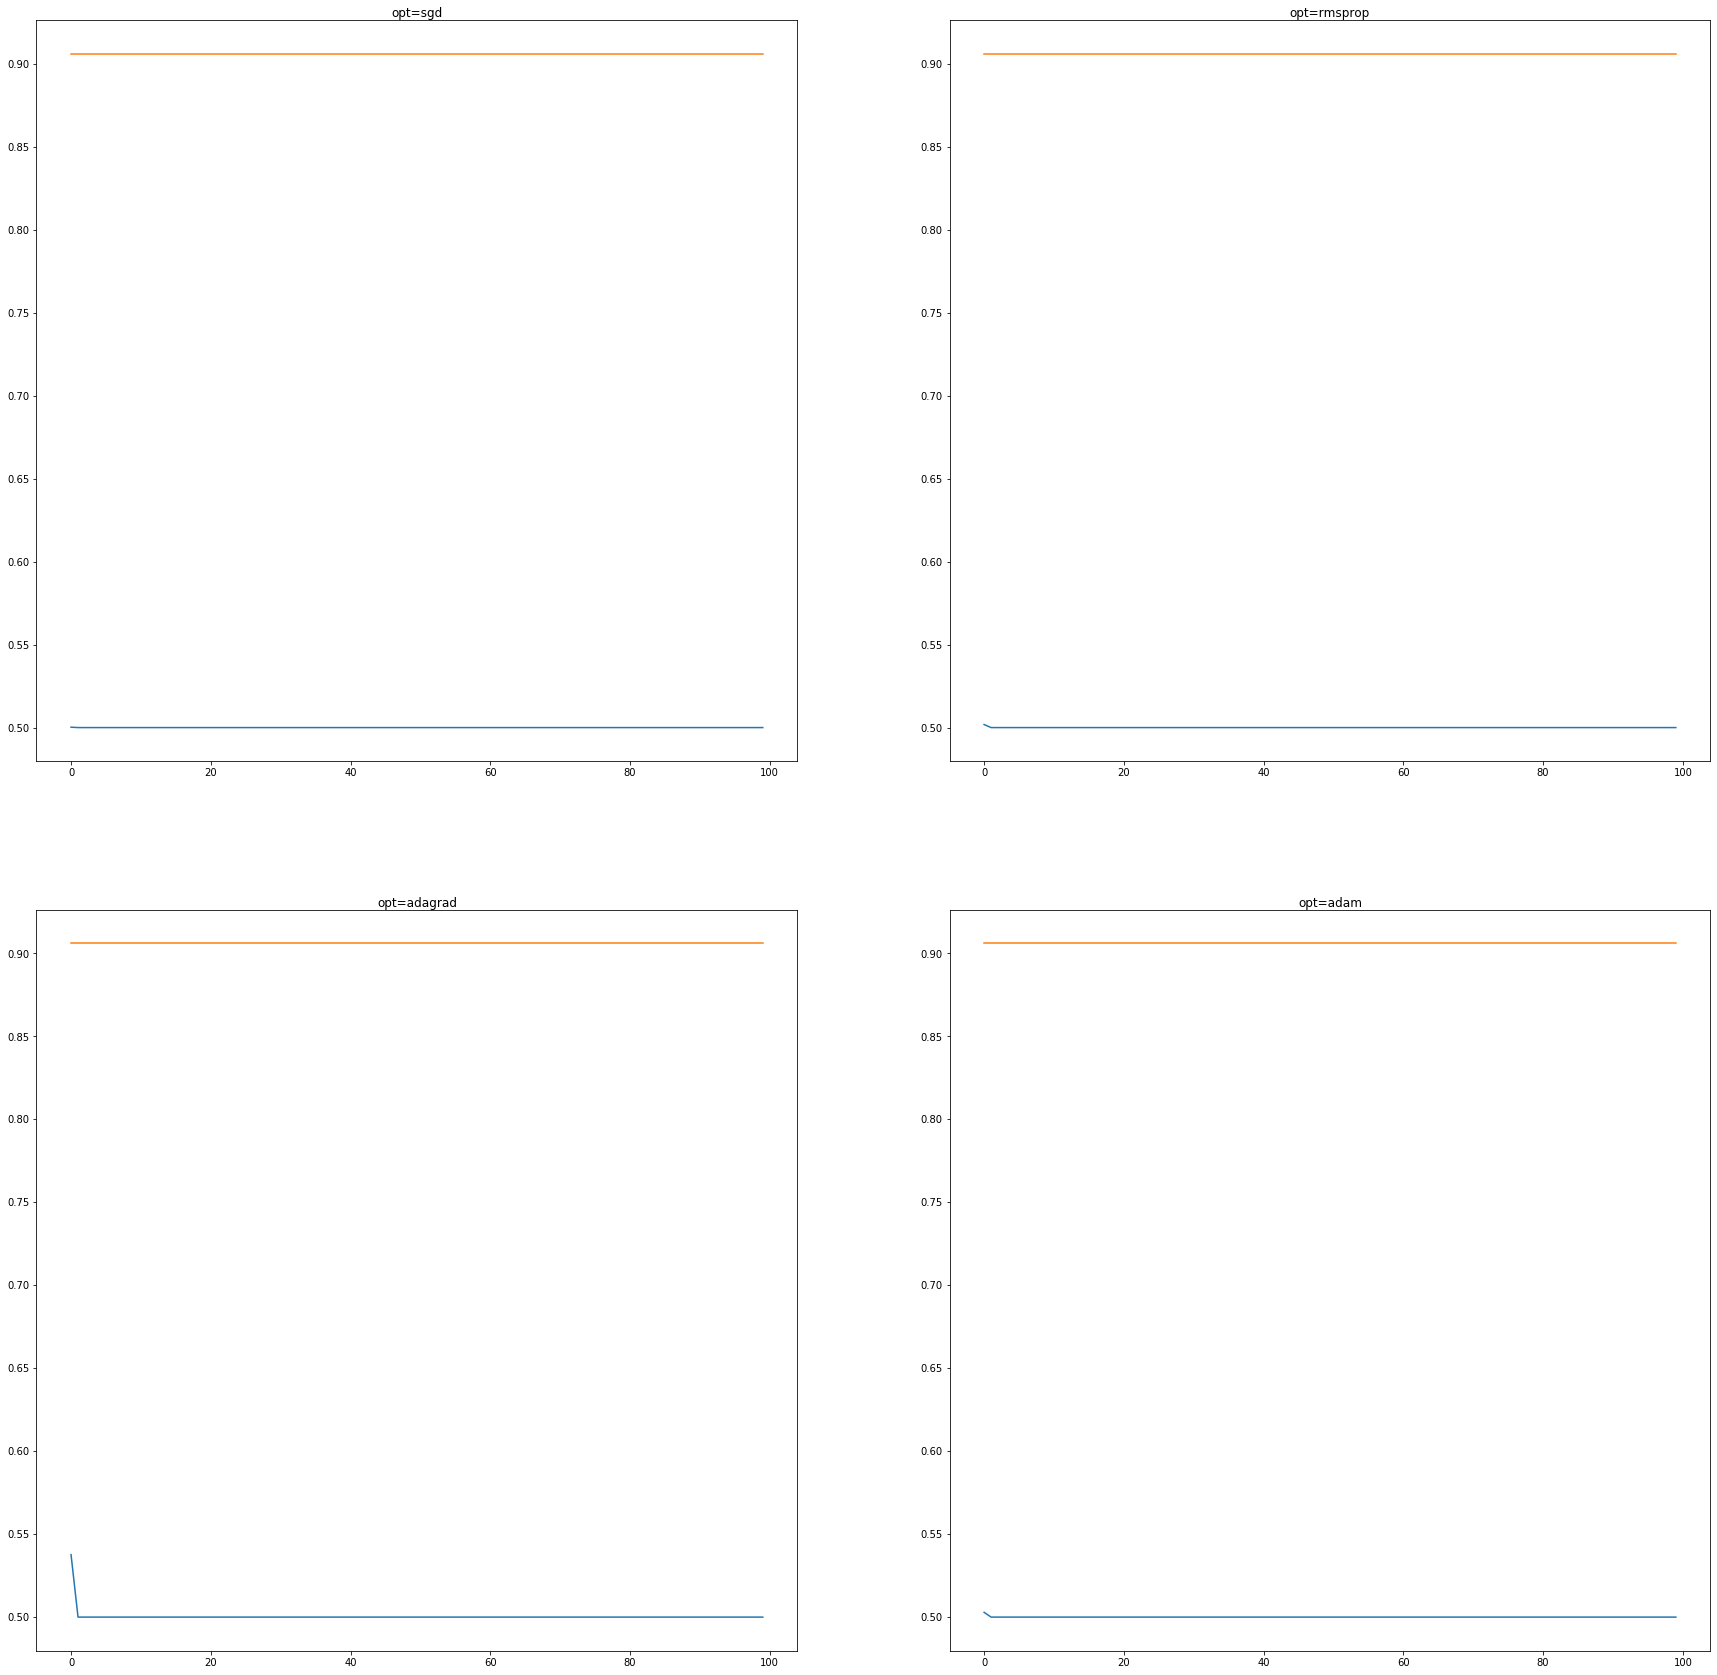

In [76]:
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
	# determine the plot number
	plot_no = 220 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model(x_scaled_train, final_y_train, X_test, y_test, momentums[i])
# show learning curves
pyplot.show()